In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np

rng = np.random.default_rng()

# Build an arena

Position inside arena will be discretized according to a hexagonal grid.

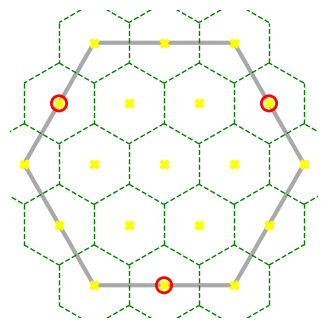

In [2]:
from hexarena.arena import Arena

arena = Arena(2)
fig, ax = plt.subplots(figsize=(4, 4))
arena.plot_mesh(ax)
fig.savefig('arena-map.png', bbox_inches='tight')

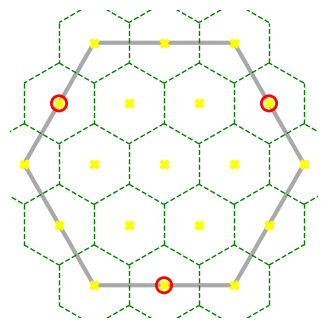

In [3]:
fig, ax = plt.subplots(figsize=(4, 4))
arena.plot_mesh(ax)
h_tile = arena.plot_tile(ax, 0, 'red')
arena.plot_tile(ax, 2, 'none', h_tile)
plt.show()

# Build a food box

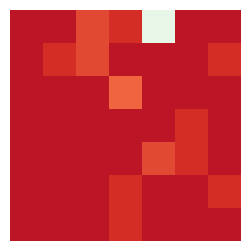

In [4]:
from hexarena.box import StationaryBox

box = StationaryBox(num_grades=20, num_patches=49, sigma=0.2)
box.reset()

fig, ax = plt.subplots(figsize=(3, 3))
h = ax.imshow(box.colors, vmin=-1, vmax=box.num_grades, cmap='RdYlBu_r')
ax.set_axis_off()

def init():
    box.reset()
    h.set_data(box.colors)
    return h,

def update(i):
    box.step(0)
    h.set_data(box.colors)
    return h,

num_frames = 80
ani = FuncAnimation(fig, update, frames=range(num_frames), init_func=init, blit=True)
ani.save('color-cues.gif')

# Build a foraging environment

In [5]:
from hexarena.env import ForagingEnv

box = {'_target_': 'hexarena.box.RestorableBox', 'num_grades': 20, 'num_patches': 49, 'sigma': 0.01}
env = ForagingEnv(
    arena={'resol': 2},
    boxes=[dict(theta_tau=tau, **box) for tau in [3, 4.2, 7]],
    monkey={'move_price': 0.},
)

## Run an example trial with random policy

In [6]:
episode = {
    'observation': [], 'action': [], 'reward': [],
    'pos': [], 'gaze': [],
    'foods': [], 'cues': [], 'colors': [],
}

def append_data(init=False):
    episode['observation'].append(observation)
    for key in info:
        episode[key].append(info[key])
    if not init:
        episode['action'].append(action)
        episode['reward'].append(reward)

observation, info = env.reset()
append_data(init=True)
for _ in range(120):
    action = env.action_space.sample()
    observation, reward, _, _, info = env.step(action)
    append_data()

for key in episode:
    episode[key] = np.array(episode[key])

rewarded = episode['reward']>0
rewarded = np.array([False, *rewarded])

push = [np.full((3,), fill_value=False)]
for action in episode['action']:
    _push, move, _ = env.monkey.convert_action(action)
    if _push:
        _push = np.full((3,), fill_value=False)
        b_idx = env.arena.boxes.index(move)
        _push[b_idx] = True
    else:
        _push = np.full((3,), fill_value=False)
    push.append(_push)
push = np.stack(push)
counts = np.stack([np.cumsum(push&rewarded[:, None], axis=0), np.cumsum(push, axis=0)], axis=2)

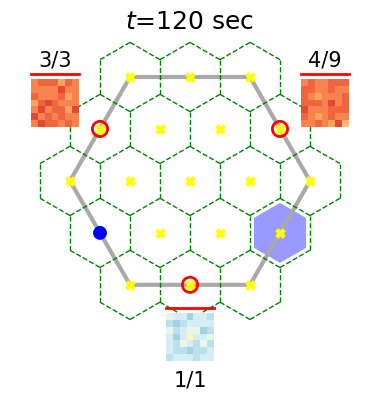

In [7]:
fig, ani = env.play_e_view(
    episode['pos'], episode['gaze'], rewarded,
    episode['foods'], episode['colors'], counts,
)
ani.save('example-trial.gif', fps=6)

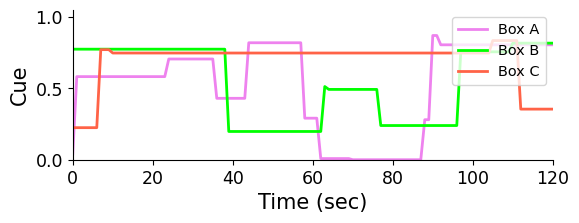

In [8]:
fig, ani = env.play_traces(episode['cues'], ylabel='Cue')
ani.save('cue-traces.gif', fps=12)